<a href="https://colab.research.google.com/github/saeu5407/Image_Multilabel/blob/main/multilable_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 작업 내용

1. train, valid 7:3으로 분리하여 작업
2. 데이터셋이 부족하여 회전 등 생성 작업을 진행하여 작업
3. 시간관계상 데이터사이즈, 모델링을 최소화하여 작업



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil
import sys
import random
import tqdm
import glob
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import (Activation, Dropout, Flatten, Dense, GlobalMaxPooling2D,
                          BatchNormalization, Input, Conv2D, GlobalAveragePooling2D, Concatenate)
# from tensorflow.keras.applications import EfficientNetB0
from keras import metrics
from keras import backend as K
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from keras.layers import *
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')

In [ ]:
"""
이미지 데이터셋 Train,Valid 분리
데이터셋은 한 경로 내에 카테고리별 폴더로 나뉘어야 한다.

as_is_path = 이미지 원본 경로
train_path = 트레이닝 세트 생성 경로
valid_path = 테스트 세트 생성 경로
split_size = 분할 비율
"""
def train_val_split(as_is_path, train_path, valid_path, split_size=0.7):

    # 기존 데이터 카테고리 폴더 확인
    # 카테고리 저장
    fold_ = os.listdir(as_is_path)
    fold_.remove('.DS_Store')

    # train set 폴더 생성
    if os.path.isdir(train_path) == False:
        os.mkdir(train_path)
    for i in fold_:
        if os.path.isdir(train_path + '/' + i) == False:
            os.mkdir(train_path + '/' + i)

    # validation set 폴더 생성
    if os.path.isdir(valid_path) == False:
        os.mkdir(valid_path)
    for i in fold_:
        if os.path.isdir(valid_path + '/' + i) == False:
            os.mkdir(valid_path + '/' + i)

    # split 실행 및 copy하여 적재
    for idx in fold_:
        listfile = os.listdir(as_is_path + '/' + idx)
        train_size = int(len(listfile)*split_size)
        print("{} | train {}, valid {} split".format(idx, train_size, len(listfile)-train_size))
        for fname in listfile[0:train_size]:
            shutil.copyfile(os.path.join(as_is_path + '/' + idx, fname),os.path.join(train_path + '/' + idx, fname))
        for fname in listfile[train_size:]:
            shutil.copyfile(os.path.join(as_is_path + '/' + idx, fname),os.path.join(valid_path + '/' + idx, fname))

In [ ]:
# 데이터셋 경로
base_path = '/content/drive/MyDrive/Git/Image_Multilabel'
as_is_path = base_path + '/data/balance'
train_path = as_is_path + '_trd'
valid_path = as_is_path + '_valid'
test_path = base_path + '/data/balance_test'

# train_val_split 함수 실행
#train_val_split(as_is_path, train_path, valid_path, split_size=0.8)

In [ ]:
# 전처리(train)
# 이미지 스케일링
trainDataGen = ImageDataGenerator(rescale=1./255, # 이미지 스케일링
                                 rotation_range = 30, # 임의로 이미지를 회전
                                 width_shift_range=0.1, # 임의로 이미지를 수평 이동
                                 height_shift_range=0.1, # 임의로 이미지를 수직 이동
                                 shear_range=0.2, # 임의로 이미지를 변형
                                 zoom_range=0.2, # 임의로 이미지를 확대/축소
                                 horizontal_flip=False, # 수평방향으로 뒤집기
                                 fill_mode='nearest' # 이미지 경계의 바깥 공간을 어떻게 채울지에 대한 파라미터
                                 )

testDataGen = ImageDataGenerator(rescale=1./255)

In [ ]:
from glob import glob
"""
MultiLable을 만들기 위한 함수
여기서는 앞에가 color, 뒤에가 item인 black_shirt.png 로 구성되어있기에 목표에 맞게 작업
향후 변경 필요시 columns= / get_dummies 등을 변경하여 사용
"""
def make_multi_lable(data_path):
    data_set = glob(data_path + '/**/*.*', recursive = True)
    dt_f = pd.DataFrame(list(map(lambda x : x.split('/')[-2].split('_'), data_set)), columns=['color','item'])
    dt_f = pd.concat([pd.get_dummies(dt_f['color']), pd.get_dummies(dt_f['item'])], axis=1)
    dt_f_col = list(dt_f.columns)
    dt_f['path'] = data_set
    dt_f
    
    return dt_f, dt_f_col

In [ ]:
# 이미지 스케일링
dt_train, dt_train_col = make_multi_lable(train_path)
dt_valid, dt_valid_col = make_multi_lable(valid_path)

# Train Set
trainGenSet = trainDataGen.flow_from_dataframe(
      dt_train,
      x_col='path',
      y_col=dt_train_col,
      batch_size=32,
      seed=42,
      shuffle=True,
      target_size=(224,224),
      class_mode='raw')

# Valid Set
testGenSet = testDataGen.flow_from_dataframe(
      dt_valid,
      x_col='path',
      y_col=dt_valid_col,
      batch_size=32,
      seed=42,
      shuffle=True,
      target_size=(224,224),
      class_mode='raw')

# Test Set
# Valid Set 그대로 셔플 제외하여 사용
finalGenSet = testDataGen.flow_from_dataframe(
      dt_valid,
      x_col='path',
      y_col=dt_valid_col,
      batch_size=32,
      seed=42,
      shuffle=False,
      target_size=(224,224),
      class_mode='raw')

# White Pants
whiteGenSet = testDataGen.flow_from_directory(
    test_path,
    target_size=(224,224),
    batch_size=32,
    class_mode=None
)

Found 3859 validated image filenames.
Found 968 validated image filenames.
Found 968 validated image filenames.
Found 1 images belonging to 1 classes.


In [21]:
#from vgg16_adj import vgg16_adj
#
#model = vgg16_adj(model_type = 'pooling',       # pooling 또는 flatten 형식 설정
#                  loss='binary_crossentropy',   # keras 기준, 필요한 loss function 설정
#                  final_dense=7,                # 최종 결과 Dense 설정
#                  final_activation='sigmoid')   # 마지막 Activation 설정

# 모델
model = Sequential()
model.add(Conv2D(64, kernel_size=(3,3), padding='same', input_shape=(224,224,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(256, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# model.add(Flatten())
model.add(GlobalAveragePooling2D())
model.add(Dense(128, activation='relu', name='after_gap'))
model.add(Dropout(0.25))
model.add(Dense(7, activation='sigmoid'))

# 학습
model.compile(loss='binary_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

model.summary()

# fig_generator
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2000)
checkpoint = ModelCheckpoint(base_path + '/model/multilabel_model.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

model.fit_generator(
    trainGenSet,
    steps_per_epoch=43,
    epochs=10,
    validation_data=testGenSet,
    validation_steps=10,
    callbacks=[early_stopping, checkpoint]
)

scores = model.evaluate_generator(testGenSet)
print(scores)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 224, 224, 64)      1792      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 56, 56, 128)       0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 56, 56, 128)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 56, 56, 256)      

In [22]:
model_ = load_model(base_path + '/model/multilabel_model.h5')
pred = model_.predict_generator(finalGenSet, steps=1)
pred_df = pd.DataFrame(pred, columns = dt_valid_col)
pred_df['path'] = dt_valid['path'][0:32]

Test set과 Valid set이 같기는 하지만 학습은 잘 되어 있다는 걸 확인할 수 있습니다.

- 정확하게는 분리해야 함

,black,blue,red,white,dress,pants,shirt,path
3,7.076976,2.593282,5.571094,71.645882,91.858032,17.818039,3.652105,/content/drive/MyDrive/Git/Image_Multilabel/da...


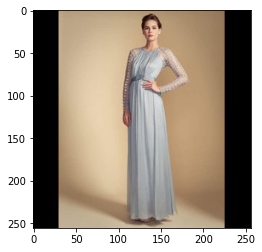

In [23]:
import matplotlib.pyplot as plt
j = 3
a = plt.imread(pred_df['path'][j])
plt.imshow(a)
pred_df.iloc[j:j+1,:] * 100

학습하지 않았던 카테고리인 White Pants에 대해서 학습했을 때, White에 대해서는 높은 스코어로 예측을 성공했지만, Pants에 대해서는 예측하지 못하는 결과를 볼 수 있었습니다.

- 학습 카테고리에 White Shirts가 존재하여 해당 카테고리에 맞게 학습된 경우

      black      blue       red     white     dress      pants      shirt
0  0.368503  1.663828  0.427848  94.71283  3.689408  11.980724  78.637398


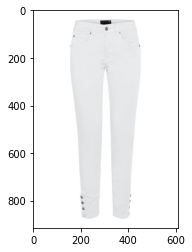

In [24]:
pred = model_.predict_generator(whiteGenSet, steps=1)
pred_df = pd.DataFrame(pred, columns = dt_valid_col)
print(pred_df*100)
a = plt.imread(glob(test_path + '/testdata/*')[0])
plt.imshow(a)

향후에 XAI에서 자세히 다루겠지만, 컨브넷의 필터를 시각화하면 이 모델이 어떤 특성을 찾는지에 대해 확인할 수 있습니다.

해당 모델에서는 바지의 전반적인 특성이 아닌 하나의 큰 이미지(색깔)을 주로 필터링하는 것으로 보입니다. 그렇기 때문에 색깔에 대해서는 좋은 정확도를 가지는 것으로 보입니다.

In [63]:
from tensorflow.keras import models

# 상위 6개 층의 출력을 추출합니다:
layer_outputs = [layer.output for layer in model.layers[:10]]
# 입력에 대해 6개 층의 출력을 반환하는 모델을 만듭니다:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)
# 층의 활성화마다 하나씩 8개의 넘파이 배열로 이루어진 리스트를 반환합니다:
activations = activation_model.predict(whiteGenSet[0])

IndexError: ignored

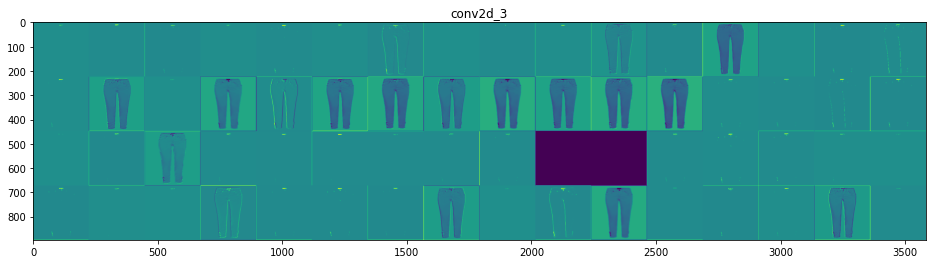

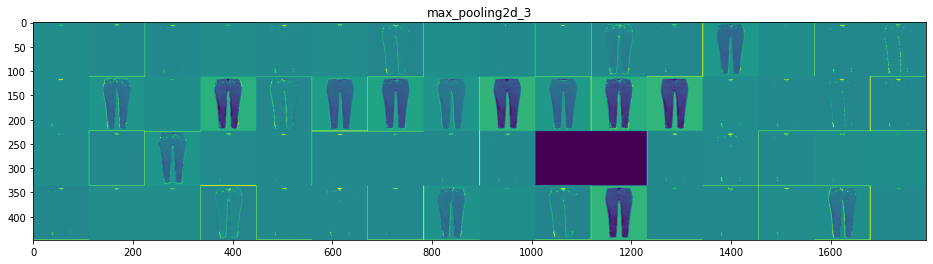

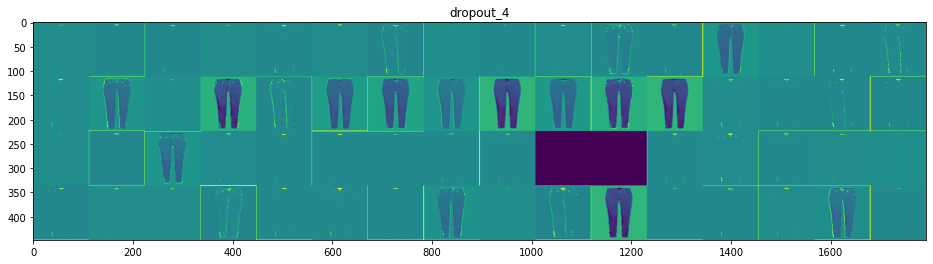

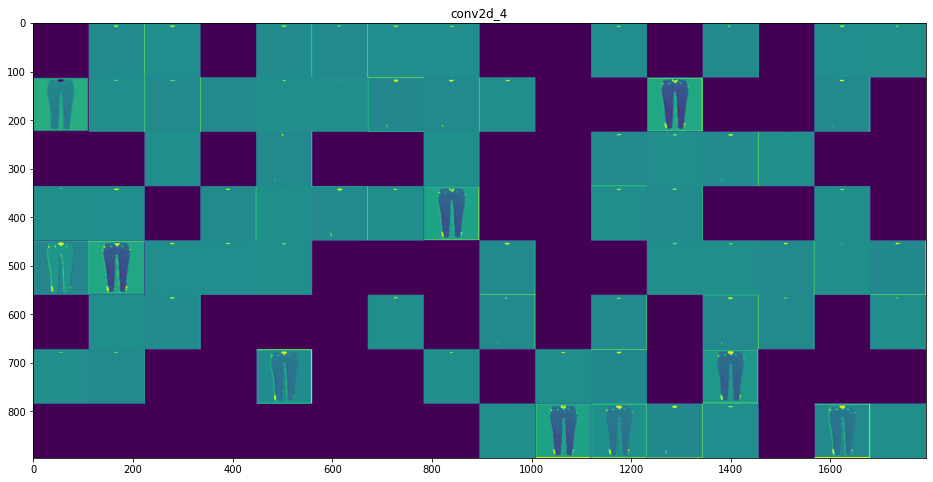

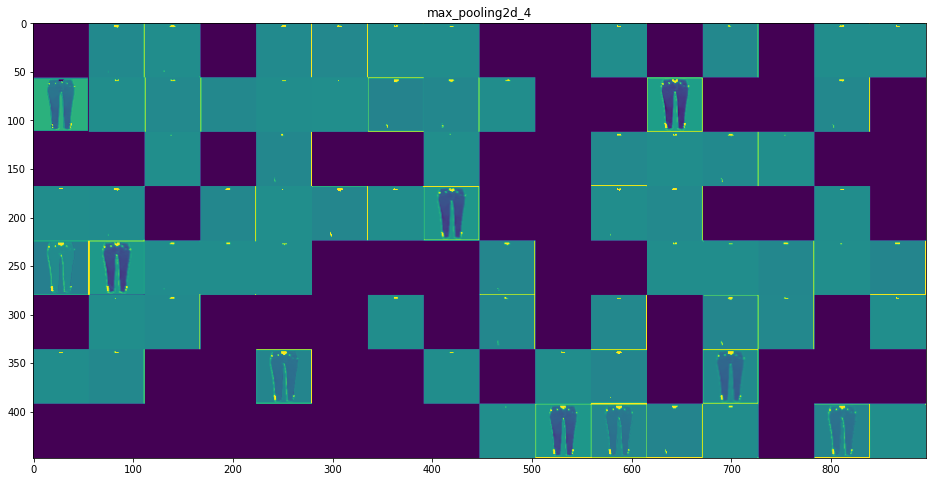

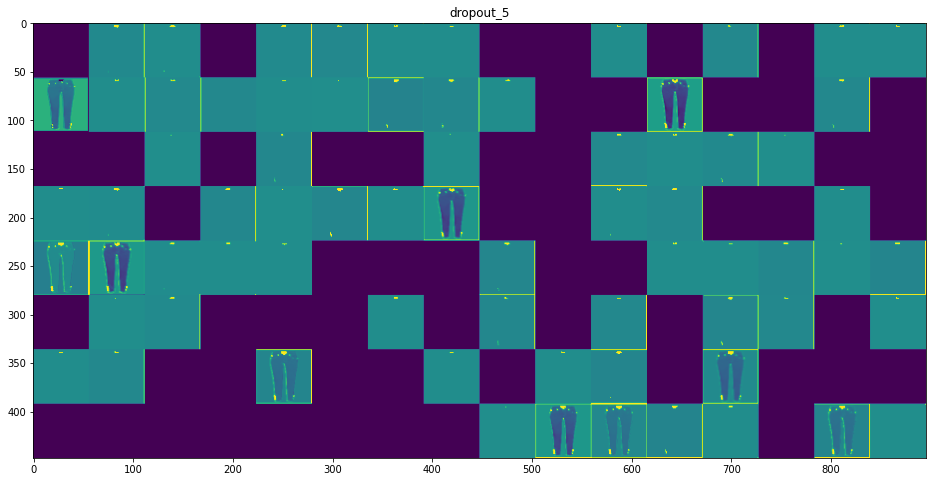

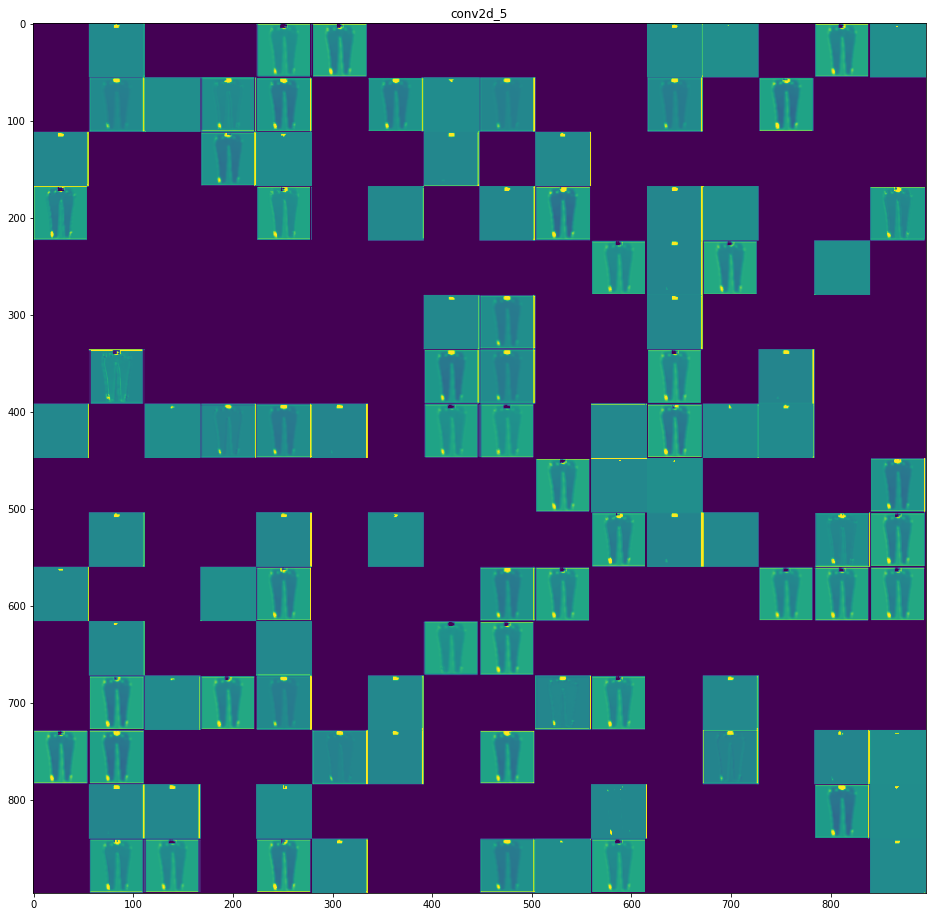

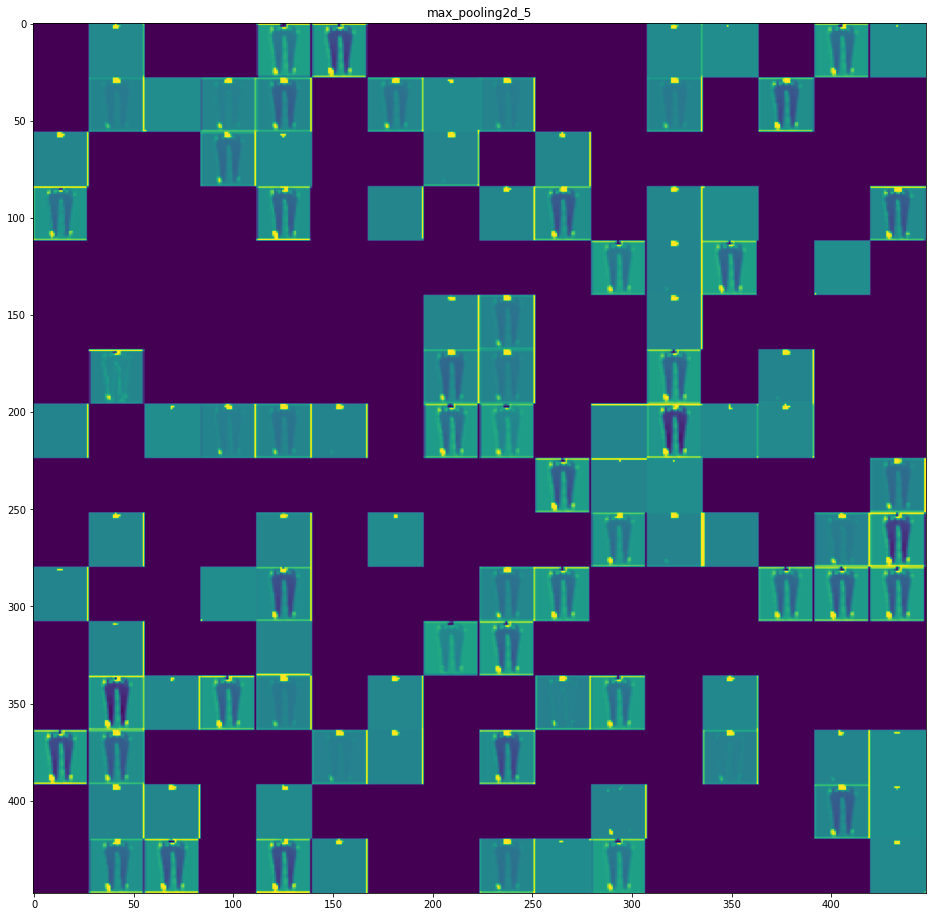

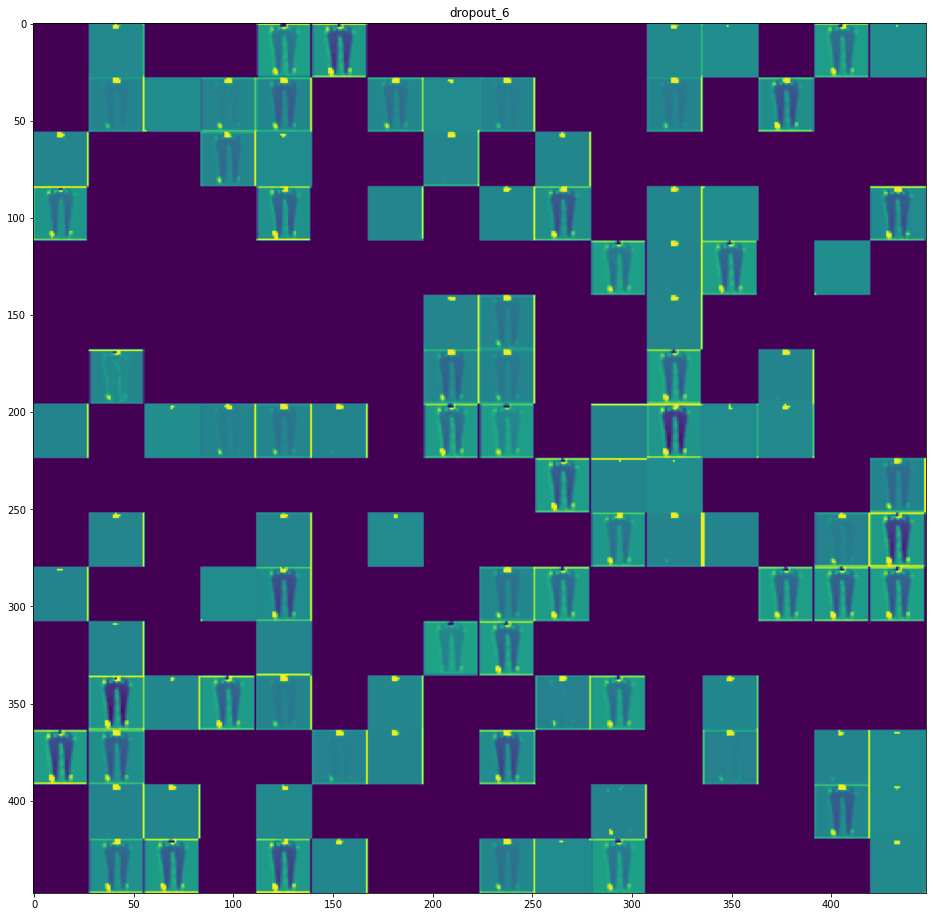

In [64]:
# 층의 이름을 그래프 제목으로 사용합니다
layer_names = []
for layer in model.layers[:10]:
    layer_names.append(layer.name)

images_per_row = 16

# 특성 맵을 그립니다
for layer_name, layer_activation in zip(layer_names, activations):
    # 특성 맵에 있는 특성의 수
    n_features = layer_activation.shape[-1]

    # 특성 맵의 크기는 (1, size, size, n_features)입니다
    size = layer_activation.shape[1]

    # 활성화 채널을 위한 그리드 크기를 구합니다
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # 각 활성화를 하나의 큰 그리드에 채웁니다
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # 그래프로 나타내기 좋게 특성을 처리합니다
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # 그리드를 출력합니다
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

plt.show()